In [1]:
import os
from pathlib import Path

from glob import glob
import pickle

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

# import torch
# import clip

from ipywidgets import interact, widgets
from tqdm.notebook import tqdm

import smart_settings

In [2]:
FOLDERS = [
    "alpha_beta_search__semantics_house_repair_100_inner3_std8_256_h32_size1_step3_control0066_nomaxdist_op3_sum",
    "alpha_beta_search__semantics_house_repair_a-white-canvas_100_inner3_std8_256_h32_size1_step3_control0066_nomaxdist_op3_best3",
    "trial__tangram_semantics_rair__60_inner3_std6_e10_256_h08_wb_s15_ff_size28_step7_cp28_control0066_staging1177_nomaxdist_op0_t1_a5_b0_rs1_best",
    "temperature_search__semantics_house_repair_100_inner3_std8_256_h32_size1_step3_control0066_nomaxdist_op3_a0_b0_sum",
    "tangram_semantics__categories_inversion_color_staging__60_inner3_std6_e20_256_h16_size1_step5_cp28_control0066_nomaxdist_op3_t1_a5_b0_rs1_best",
    "tangram__semantics_rair__5_tree_60_inner3_std6_e20_256_h08_wb_sc15_xsize28_rsize4_xstep7_cp28_op0_staging1177_t1_a5_b0_rs1_best_dn_x2",
    "tangram__semantics__N_tree_30_inner3_std6_e20_256_h08_c_s15_xsize28_rsize4_xstep7_cp28_op0_t1_a5_b0_rs1_best_dn_x3",
    "tangram__semantics__N_tree_30_inner3_std6_e20_256_h08_c_s15_xsize28_rsize4_xstep7_cp28_op0_staging1199_t1_a5_b0_rs1_best_dn_x3",
    "tangram__semantics__N_tree_30_inner3_std6_e10_256_h08_c_s15_xsize28_rsize4_xstep7_cp28_op0_t1_a5_b0_rs1_best_dn_x3",
    "tangram__semantics__N_tree_30_inner3_std6_e10_256_h08_c_s15_xsize28_rsize4_xstep7_cp28_op0_staging1199_t1_a5_b0_rs1_best_dn_x3",
    "semantics_search_60_inner3_std6_e20_256_control0066_nomaxdist_t1_a5_b0_rs1_best",  #
    "semantics_search_60_inner3_std6_256_size1_control0066_nomaxdist_b0_best",  # 1
    "model_search_semantics_60_inner3_std6_e20_256_h16_size1_step5_control0066_nomaxdist_t1_15_b0_rs1_best",
    "cost_along_traj_search_2__semantics_house_repair_100_inner3_std8_256_h32_size1_step3_control0066_nomaxdist_op3_a0_b0",
    "cost_along_traj_search__semantics_house_repair_200_inner3_std8_128_h8_size1_step3_control0066_nomaxdist_op3_a0_b0",
    "controller_init_std_search__semantics_house_repair_100_inner3_256_h32_size1_step3_control0066_nomaxdist_op3_a0_b0_sum",
    "closeness_100_inner3_256_control0066_nomaxdist_best_x3",
    "alpha_beta_search__semantics_tree_repair_100_inner3_std8_256_h32_size1_step3_control0066_nomaxdist_op3_sum"
]
FOLDERS = dict(zip(range(len(FOLDERS)), FOLDERS))
FRAMES = 60

In [3]:
def extract_settings(params):
    return (
        params.controller_params.compression,
        params.controller_params.render_kwargs.invert,
        params.controller_params.render_kwargs.color,
        params.controller_params.semantics_baseline,
        params.controller_params.action_sampler_params.opt_iterations,
        params.controller_params.action_sampler_params.init_std,
        params.controller_params.action_sampler_params.elites_size,
        params.controller_params.num_simulated_trajectories,
        params.controller_params.horizon,
        params.env_params.x_size,
        params.env_params.get("r_size", 4),
        params.env_params.x_step,
        params.controller_params.get('compression_precision', params.controller_params.get('precision')),
        str(params.env_params.get("staging_boundaries", [[0, 0], [1., 1.]])),
        params.env_params.object_persistency,
        params.controller_params.semantics_model_temperature,
        params.controller_params.semantics_alpha_target,
        params.controller_params.semantics_beta_image,
        params.controller_params.semantics_reward_scale,
        params.controller_params.cost_along_trajectory,
        params.get("seed", params.env_params.get("seed", None))
    )

results = pd.DataFrame(columns=[
    # "shape",
    "rair",
    "inversion",
    "color",
    "baseline",
    "opt_iterations",
    "init_std",
    "elites_size",
    "num_simulated_trajectories",
    "horizon",
    "x_size",
    "r_size",
    "x_step",
    "compression_precision",
    "staging_boundaries",
    "object_persistency",
    "temperature",
    "alpha_target",
    "beta_image",
    "reward_scale",
    "cost_along_trajectory",
    "seed",
    "completed",
    "sum_entropies",
    "final_entropy"
])

In [4]:
# distribution = dict()
entropies = dict()
for id, folder in FOLDERS.items():
    for job in tqdm(os.listdir(folder)):
        params = smart_settings.load(os.path.join(folder, job, "settings.toml"), make_immutable=False)
        try:
            with open(glob(os.path.join(folder, job, "results*.pickle"))[0], "rb") as resultfile:
                probs = np.asarray(list(pickle.load(resultfile).values()))
        except (IndexError, FileNotFoundError):
            print(f"> Results not found for {folder}/{job}")
            completed = False
            entropies[f'{id}_{job}'] = None
            # distribution[f'{id}_{job}'] = None
        else:
            completed = True
            entropies[f'{id}_{job}'] = -np.einsum('ij,ji->i', probs, np.log(np.where(probs == 0, 1, probs)).T)
            # distribution[f'{id}_{job}'] = probs
        results.loc[f'{id}_{job}'] = [*extract_settings(params), completed, entropies[f'{id}_{job}'].sum() if completed else np.nan, entropies[f'{id}_{job}'][-1] if completed else np.nan]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

> Results not found for semantics_search_60_inner3_std6_e20_256_control0066_nomaxdist_t1_a5_b0_rs1_best/64


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

> Results not found for closeness_100_inner3_256_control0066_nomaxdist_best_x3/10


  0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
compute = lambda f, entropies=entropies, alt=np.nan: pd.Series(map(lambda x: (alt if x is None else f(x)), entropies.values()), entropies.keys())

In [6]:
results['sum_entropies_normalized'] = compute(lambda x: x.sum() / x.max())
results['sum_entropies_centered'] = compute(lambda x: (x - x.max()).sum())
# results['reached'] = compute(lambda x: (x < 1).any(), alt=False)

In [7]:
results.sort_values("sum_entropies", inplace=True)
# results["complexity"] = results["horizon"] * results["num_simulated_trajectories"]

``` sh
gram semantics_search_60_inner3_std6_256_size1_control0066_nomaxdist_b0_best/$1 --save-path results/tangram_videos/new_semantics/semantics_search_60_inner3_std6_256_size1_control0066_nomaxdist_b0_best/$1
```

In [8]:
# Best performing -- 105
results.iloc[0]

rair                                          True
inversion                                    False
color                                         True
baseline                            A white canvas
opt_iterations                                   3
init_std                                       0.6
elites_size                                     20
num_simulated_trajectories                     256
horizon                                         24
x_size                                          28
r_size                                           4
x_step                                           7
compression_precision                           28
staging_boundaries            [[0, 0], [1.0, 1.0]]
object_persistency                               0
temperature                                    1.0
alpha_target                                   0.5
beta_image                                     0.0
reward_scale                                   1.0
cost_along_trajectory          

In [9]:
# plt.scatter(range(len(results)), results["sum_entropies"], s=0.05)  # c=results["cost_along_trajectory"].replace({"best": "r", "sum": "b"})

In [10]:
# results["XIC"] = np.log(results["sum_entropies"]) + results["complexity"]
# results.sort_values("XIC")

In [11]:
results

,rair,inversion,color,baseline,opt_iterations,init_std,elites_size,num_simulated_trajectories,horizon,x_size,...,alpha_target,beta_image,reward_scale,cost_along_trajectory,seed,completed,sum_entropies,final_entropy,sum_entropies_normalized,sum_entropies_centered
10_112,True,False,True,A white canvas,3,0.6,20,256,24,28,...,0.5,0.0,1.0,best,2208986566,True,2.964844,0.013260,1.537109,-114.687500
7_2,False,False,True,A white canvas,3,0.6,20,256,8,28,...,0.5,0.0,1.0,best,973970085,True,2.998047,0.000672,1.747070,-50.187500
10_84,True,False,True,A white canvas,3,0.6,20,256,24,1,...,0.5,0.0,1.0,best,2112382376,True,3.822266,0.010246,2.421875,-92.437500
8_2,False,False,True,A white canvas,3,0.6,10,256,8,28,...,0.5,0.0,1.0,best,100547005,True,4.363281,0.001813,2.447266,-50.875000
6_2,False,False,True,A white canvas,3,0.6,20,256,8,28,...,0.5,0.0,1.0,best,883529372,True,4.531250,0.000987,3.203125,-39.343750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17_4,False,False,True,/is/sg2/pgoyal/Desktop/Projects/mbrl-semantics...,3,0.8,10,256,32,1,...,0.5,0.5,6.0,sum,232405654,True,211.625000,2.138672,98.937500,-4.421875
17_3,False,False,True,/is/sg2/pgoyal/Desktop/Projects/mbrl-semantics...,3,0.8,10,256,32,1,...,0.5,0.0,6.0,sum,2019543195,True,223.375000,2.205078,99.000000,-4.441406
1_1,False,False,True,A white canvas,3,0.8,10,256,32,1,...,0.5,-0.5,6.0,3,3668780133,True,223.750000,2.242188,97.687500,-7.664062
10_64,True,False,True,A white canvas,3,0.6,20,256,16,28,...,0.5,0.0,1.0,best,1472629184,False,NaN,NaN,NaN,NaN


In [17]:
mask = results['completed'] & (results['x_size'] == 1) & (results['object_persistency'] != 0)
print(mask.sum())
interact(lambda x, y="sum_entropies": sns.boxplot(x=x, y=y, data=results[mask]), x=results.columns, y=results.columns)

424


interactive(children=(Dropdown(description='x', options=('rair', 'inversion', 'color', 'baseline', 'opt_iterat…

<function __main__.<lambda>(x, y='sum_entropies')>

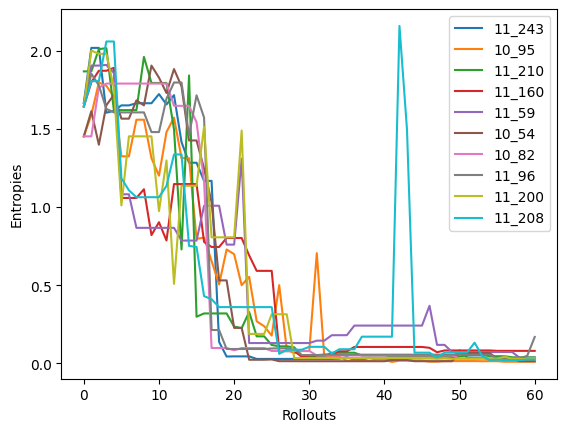

In [22]:
for key, row in results[200:210].iterrows():
    plt.plot(entropies[key], label=key)
plt.xlabel("Rollouts")
plt.ylabel("Entropies")
plt.legend();

In [ ]:
# tree_576
# house_951